#**스마트폰 센서 데이터 기반 모션 분류**
# 단계2 : 기본 모델링


## 0.미션3

* 데이터 전처리
    * 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리 수행
* 다양한 딥러닝 구조의 모델로 분류 모델 생성
    * 최소 4개 이상 모델링 수행
    * (옵션)각 모델별 최소 5회 반복수행해서 얻은 성능의 평균으로 비교
    * (옵션)각 모델의 성능을 저장하는 별도 데이터 프레임을 만들고 비교
* 옵션 : 다음 사항은 선택사항입니다. 시간이 허용하는 범위 내에서 수행하세요.
    * 상위 N개 변수를 선정하여 모델링 및 성능 비교
        * 모델링에 항상 모든 변수가 필요한 것은 아닙니다.
        * 변수 중요도 상위 N개를 선정하여 모델링하고 타 모델과 성능을 비교하세요.
        * 상위 N개를 선택하는 방법은, 변수를 하나씩 늘려가며 모델링 및 성능 검증을 수행하여 적절한 지점을 찾는 것입니다.
* 성능 가이드
    * Accuracy : 0.90 ~ 0.99

## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project3 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

* 구글 드라이브 연결

In [162]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [163]:
path = '/content/drive/MyDrive/mini_project3/'

### (2) 라이브러리 불러오기

* 라이브러리 로딩

In [223]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import *

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Input
from keras.backend import clear_session
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

In [165]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

#### 1) 데이터로딩

In [166]:
data_train = pd.read_csv(path + 'data01_train.csv')
data_test = pd.read_csv(path + 'data01_test.csv')
features = pd.read_csv(path + 'features.csv')

In [167]:
data_train.drop(columns=['subject'], inplace=True)
data_test.drop(columns=['subject'], inplace=True)

In [168]:
data_train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS


#### 2) 기본 정보 조회

In [8]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Columns: 562 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), object(1)
memory usage: 25.2+ MB


In [9]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561 entries, 0 to 560
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   sensor        561 non-null    object
 1   agg           561 non-null    object
 2   axis          436 non-null    object
 3   feature_name  561 non-null    object
dtypes: object(4)
memory usage: 17.7+ KB


In [66]:
data_test.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.284379,-0.021981,-0.116683,-0.992490,-0.979640,-0.963321,-0.992563,-0.977304,-0.958142,-0.938850,...,-0.509523,-0.850065,-0.018043,0.092304,0.074220,-0.714534,-0.671943,-0.018351,-0.185733,SITTING
1,0.277440,-0.028086,-0.118412,-0.996620,-0.927676,-0.972294,-0.997346,-0.931405,-0.971788,-0.939837,...,-0.210792,-0.613367,-0.022456,-0.155414,0.247498,-0.112257,-0.826816,0.184489,-0.068699,STANDING
2,0.305833,-0.041023,-0.087303,0.006880,0.182800,-0.237984,0.005642,0.028616,-0.236474,0.016311,...,0.579587,0.394388,-0.362616,0.171069,0.576349,-0.688314,-0.743234,0.272186,0.053101,WALKING
3,0.276053,-0.016487,-0.108381,-0.995379,-0.983978,-0.975854,-0.995877,-0.985280,-0.974907,-0.941425,...,-0.566291,-0.841455,0.289548,0.079801,-0.020033,0.291898,-0.639435,-0.111998,-0.123298,SITTING
4,0.271998,0.016904,-0.078856,-0.973468,-0.702462,-0.869450,-0.979810,-0.711601,-0.856807,-0.920760,...,0.447577,0.214219,0.010111,0.114179,-0.830776,-0.325098,-0.840817,0.116237,-0.096615,STANDING


## **2. 데이터 전처리**

* 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리를 수행한다.


### (1) 데이터 분할1 : x, y

* 세부 요구사항
    - x, y로 분할합니다.

In [10]:
print((data_train.isna().sum() > 0).any())

False


In [ ]:
target = 'Activity'

x = data_train.drop(columns=[target])
y = data_train[target]

In [169]:
def data_pipe(target, data, encoder=LabelEncoder()):
  x = data.drop(columns=[target])
  y = data[target]

  x_s = MinMaxScaler().fit_transform(x)

  encoded_y = pd.DataFrame()
  encoded_y[target] = encoder.fit_transform(y)

  return x_s, encoded_y

In [203]:
def estimate(model, x, y, encode='sparse'):
  pred = model.predict(x).argmax(axis=1)

  if encode == 'onehot':
    y = y.argmax(axis=1)

  print()
  print(confusion_matrix(y, pred))
  print()
  print('-'*60)
  print()
  print(classification_report(y, pred))

  return round(accuracy_score(y, pred),4)

### (2) 스케일링


* 세부 요구사항
    - 스케일링을 필요로 하는 알고리즘 사용을 위해서 코드 수행
    - min-max 방식 혹은 standard 방식 중 한가지 사용.

In [53]:
scaler = MinMaxScaler()
x_s = scaler.fit_transform(x)

### (3) Y 전처리
* integer encoding : LabelEncoder
* (필요시) one-hot encoding

In [38]:
int_y = pd.DataFrame()
int_y['Activity'] = LabelEncoder().fit_transform(y)

In [39]:
int_y

,Activity
0,2
1,0
2,2
3,3
4,4
...,...
5876,1
5877,5
5878,0
5879,5


In [47]:
data_train[['Activity']]

,Activity
0,STANDING
1,LAYING
2,STANDING
3,WALKING
4,WALKING_DOWNSTAIRS
...,...
5876,SITTING
5877,WALKING_UPSTAIRS
5878,LAYING
5879,WALKING_UPSTAIRS


In [48]:
oneHot_y = OneHotEncoder().fit_transform(data_train[['Activity']])

In [50]:
oneHot_y.toarray()

array([[0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0.]])

### (4) 데이터분할2 : train, validation

* 세부 요구사항
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

In [171]:
# data_pipe를 통해 스케일링된 x와 인코딩된 y값 반환
x,y = data_pipe(target='Activity', data=data_train)

In [100]:
#oneHot_y = to_categorical(y,6)

In [101]:
#oneHot_y

array([[0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0.]])

In [172]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=1)

In [102]:
#x_train, x_val, y_train, y_val = train_test_split(x_s, oneHot_y, test_size=0.2, random_state=1)

## **3. 기본 모델링**



* 세부 요구사항
    - 모델1 : Base line 모델
        * Hidden Layer 없이 모델 생성
    - 모델2 : 복잡한 모델 생성
        * 최소 5개 이상의 은닉층을 추가한 모델
    - 모델3 ~ n : 튜닝 모델
        * 학습률, epoch 등 조정
        * 모델2에 과적합을 방지하기 위한 규제 기법 추가
        * Accuracy 최대화 시키는 모델 생성하기
    - 각 모델은 최소 5번 반복수행해서 얻은 성능의 평균값을 기록

In [231]:
def model_compile_fit(model, ep = 30, lr = 0.01, callback=[]):
  model.compile(optimizer=Adam(learning_rate=lr), loss='sparse_categorical_crossentropy')

  if len(callback) > 0:
    hist = model.fit(x_train, y_train, epochs=ep, validation_data=(x_val, y_val), verbose=0, callbacks=callback)
  else:
    hist = model.fit(x_train, y_train, epochs=ep, validation_data=(x_val, y_val), verbose=0)

  dl_history_plot(hist.history)

  return model

### (1) 모델1

In [55]:
nfeatures = x_train.shape[1]
nfeatures

561

In [184]:
clear_session()

base_model = Sequential([Input(shape = (nfeatures,)),
                         Dense(6, activation='softmax')])

base_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 6)                   │           3,372 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,372 (13.17 KB)

 Trainable params: 3,372 (13.17 KB)

 Non-trainable params: 0 (0.00 B)

In [120]:
base_model.compile(optimizer=Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy')

In [121]:
hist1 = base_model.fit(x_train, y_train, epochs=100, validation_data=(x_val, y_val), verbose=0)

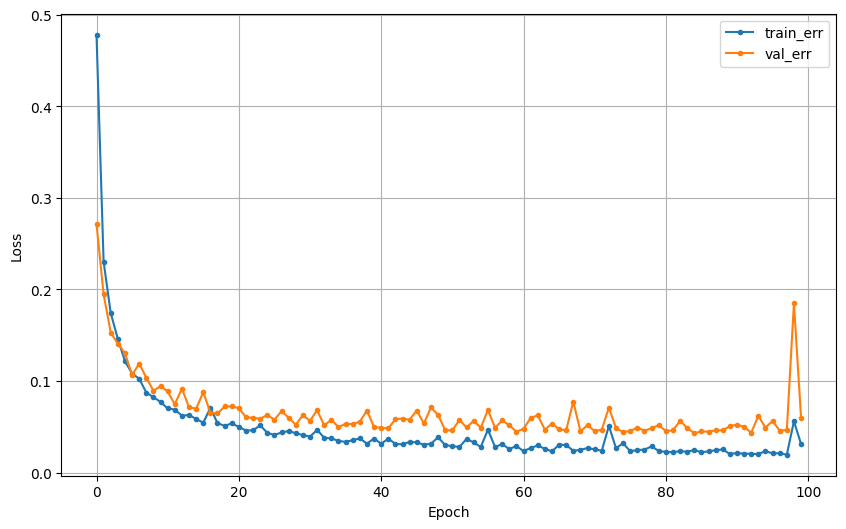

In [122]:
dl_history_plot(hist1.history)

In [60]:
pred1 = base_model.predict(x_val).argmax(axis=1)

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [126]:
print(classification_report(y_val, pred1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       222
           1       0.95      0.96      0.96       198
           2       0.97      0.96      0.97       235
           3       0.99      1.00      1.00       192
           4       1.00      0.99      1.00       156
           5       1.00      1.00      1.00       174

    accuracy                           0.98      1177
   macro avg       0.99      0.99      0.99      1177
weighted avg       0.98      0.98      0.98      1177



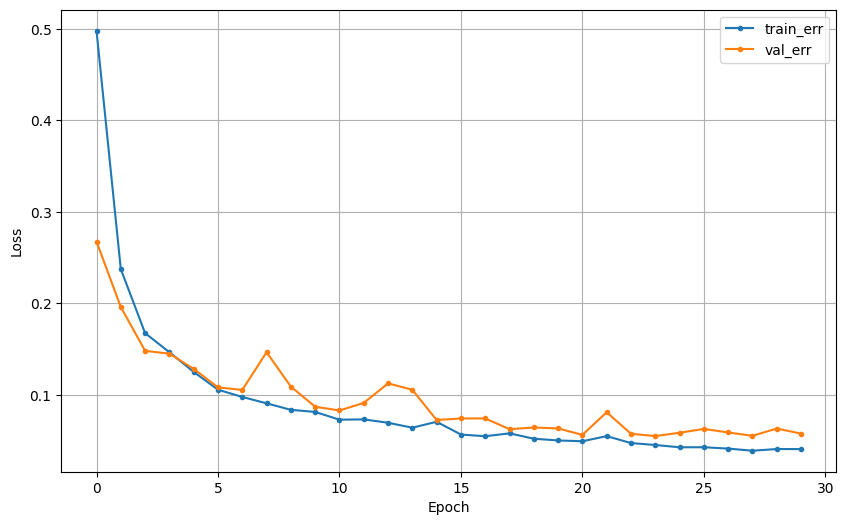

In [185]:
base_model = model_compile_fit(base_model, ep=30, lr=0.01)

In [186]:
estimate(base_model, x_val, y_val)

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

[[222   0   0   0   0   0]
 [  0 187  11   0   0   0]
 [  0   8 227   0   0   0]
 [  0   0   0 192   0   0]
 [  0   0   0   3 153   0]
 [  0   0   0   2   0 172]]

------------------------------------------------------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       222
           1       0.96      0.94      0.95       198
           2       0.95      0.97      0.96       235
           3       0.97      1.00      0.99       192
           4       1.00      0.98      0.99       156
           5       1.00      0.99      0.99       174

    accuracy                           0.98      1177
   macro avg       0.98      0.98      0.98      1177
weighted avg       0.98      0.98      0.98      1177



In [187]:
x_test, y_test = data_pipe(target='Activity', data=data_test)

In [188]:
estimate(base_model, x_test, y_test)

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

[[291   0   0   0   1   0]
 [  0 220  34   0   0   0]
 [  0   5 282   0   0   0]
 [  0   0   0 228   0   0]
 [  0   0   0   3 192   0]
 [  0   0   0  11   1 203]]

------------------------------------------------------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       292
           1       0.98      0.87      0.92       254
           2       0.89      0.98      0.94       287
           3       0.94      1.00      0.97       228
           4       0.99      0.98      0.99       195
           5       1.00      0.94      0.97       215

    accuracy                           0.96      1471
   macro avg       0.97      0.96      0.96      1471
weighted avg       0.96      0.96      0.96      1471



### (2) 모델2

In [210]:
def modeling2():
  clear_session()

  model2 = Sequential([Input(shape = (nfeatures,)),
                      Dense(64, activation='relu'),
                      Dense(32, activation='relu'),
                      Dense(16, activation='relu'),
                      Dense(6, activation='softmax')])
  return model2

#model2.summary()

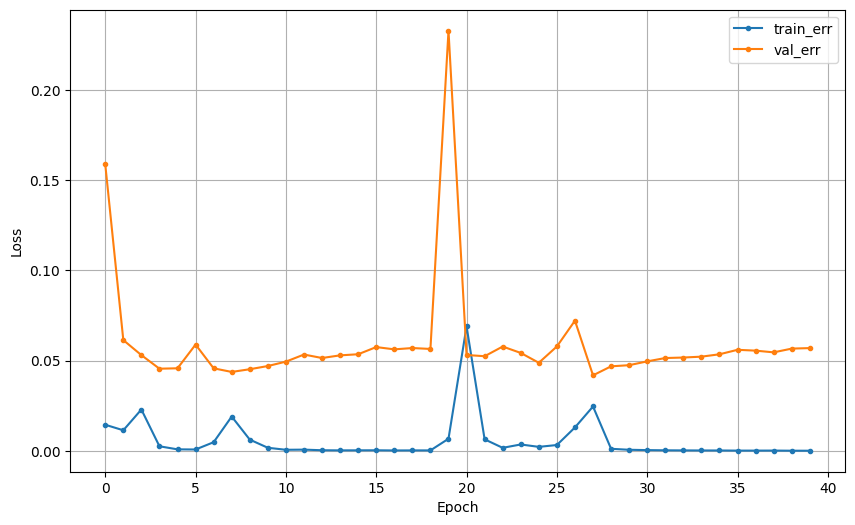

In [199]:
model2 = model_compile_fit(model2, ep=40, lr=0.0005)

In [204]:
print(estimate(model2, x_val, y_val))

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

[[222   0   0   0   0   0]
 [  0 191   7   0   0   0]
 [  0   7 228   0   0   0]
 [  0   0   0 192   0   0]
 [  0   0   0   1 155   0]
 [  0   0   0   0   0 174]]

------------------------------------------------------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       222
           1       0.96      0.96      0.96       198
           2       0.97      0.97      0.97       235
           3       0.99      1.00      1.00       192
           4       1.00      0.99      1.00       156
           5       1.00      1.00      1.00       174

    accuracy                           0.99      1177
   macro avg       0.99      0.99      0.99      1177
weighted avg       0.99      0.99      0.99      1177

0.9873


In [205]:
print(estimate(model2, x_test, y_test))

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

[[290   2   0   0   0   0]
 [  0 214  40   0   0   0]
 [  0   3 284   0   0   0]
 [  0   0   0 228   0   0]
 [  0   0   0   3 192   0]
 [  0   0   0   7   1 207]]

------------------------------------------------------------

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       292
           1       0.98      0.84      0.90       254
           2       0.88      0.99      0.93       287
           3       0.96      1.00      0.98       228
           4       0.99      0.98      0.99       195
           5       1.00      0.96      0.98       215

    accuracy                           0.96      1471
   macro avg       0.97      0.96      0.96      1471
weighted avg       0.96      0.96      0.96      1471

0.9619


In [238]:
# 하이퍼 파람 튜닝
def hyperparameter_tuning(modeling, callback=[]):
  epochs = [100, 200, 250]
  learning_rates = [0.001, 0.0005]
  max_accuracy = 0
  best_epoch = 0
  best_lr = 0
  model_final = modeling()

  for ep in epochs:
    for lr in learning_rates:
      tmp_model = model_compile_fit(modeling(), ep=ep, lr=lr, callback=callback)
      tmp_acc = estimate(tmp_model, x_test, y_test)
      if max_accuracy < tmp_acc:
        max_accuracy = tmp_acc
        best_epoch = ep
        best_lr = lr
        model_final = tmp_model

  return model_final, max_accuracy, best_epoch, best_lr

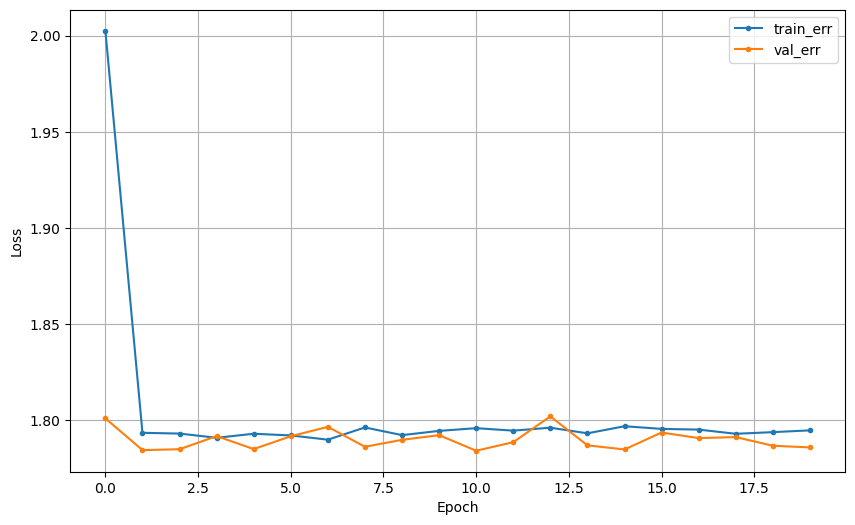

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

[[292   0   0   0   0   0]
 [254   0   0   0   0   0]
 [287   0   0   0   0   0]
 [228   0   0   0   0   0]
 [195   0   0   0   0   0]
 [215   0   0   0   0   0]]

------------------------------------------------------------

              precision    recall  f1-score   support

           0       0.20      1.00      0.33       292
           1       0.00      0.00      0.00       254
           2       0.00      0.00      0.00       287
           3       0.00      0.00      0.00       228
           4       0.00      0.00      0.00       195
           5       0.00      0.00      0.00       215

    accuracy                           0.20      1471
   macro avg       0.03      0.17      0.06      1471
weighted avg       0.04      0.20      0.07      1471



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


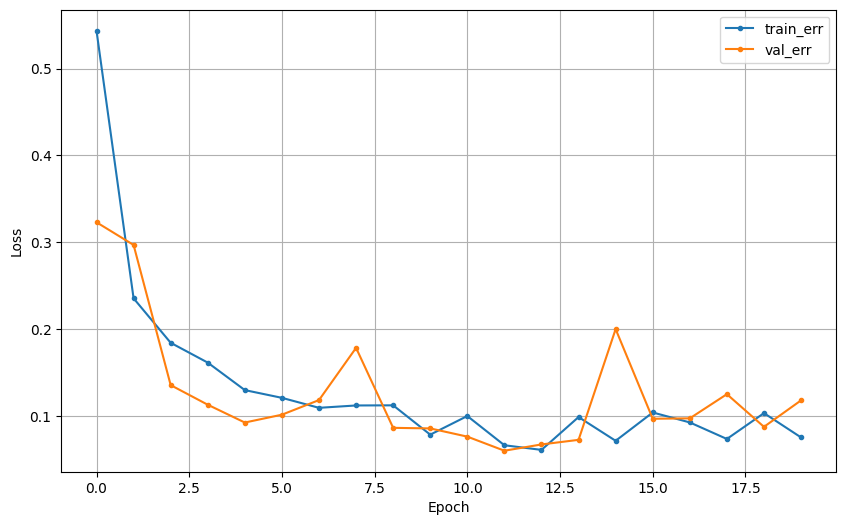

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

[[292   0   0   0   0   0]
 [  0 248   6   0   0   0]
 [  0  29 258   0   0   0]
 [  0   0   0 228   0   0]
 [  0   0   0   2 193   0]
 [  0   0   0  11   5 199]]

------------------------------------------------------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       292
           1       0.90      0.98      0.93       254
           2       0.98      0.90      0.94       287
           3       0.95      1.00      0.97       228
           4       0.97      0.99      0.98       195
           5       1.00      0.93      0.96       215

    accuracy                           0.96      1471
   macro avg       0.97      0.97      0.96      1471
weighted avg       0.97      0.96      0.96      1471



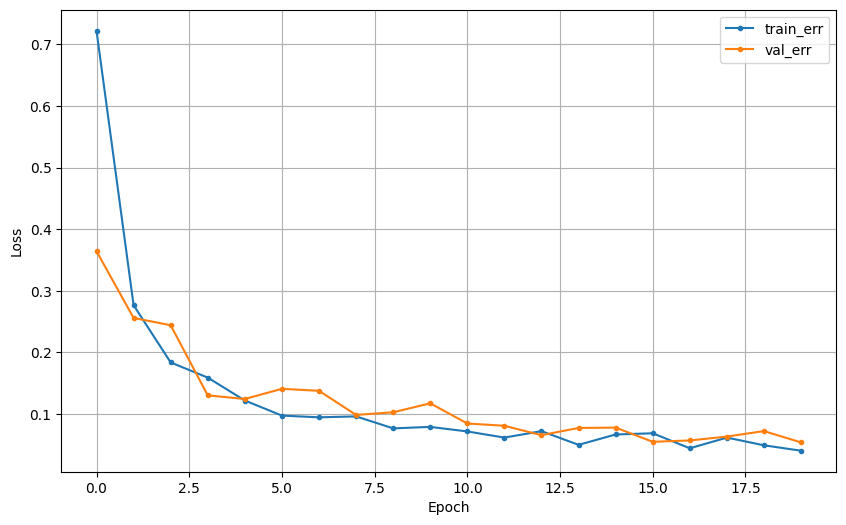

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

[[292   0   0   0   0   0]
 [  0 232  22   0   0   0]
 [  0   9 278   0   0   0]
 [  0   0   0 228   0   0]
 [  0   0   0   3 192   0]
 [  0   0   1  10   2 202]]

------------------------------------------------------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       292
           1       0.96      0.91      0.94       254
           2       0.92      0.97      0.95       287
           3       0.95      1.00      0.97       228
           4       0.99      0.98      0.99       195
           5       1.00      0.94      0.97       215

    accuracy                           0.97      1471
   macro avg       0.97      0.97      0.97      1471
weighted avg       0.97      0.97      0.97      1471



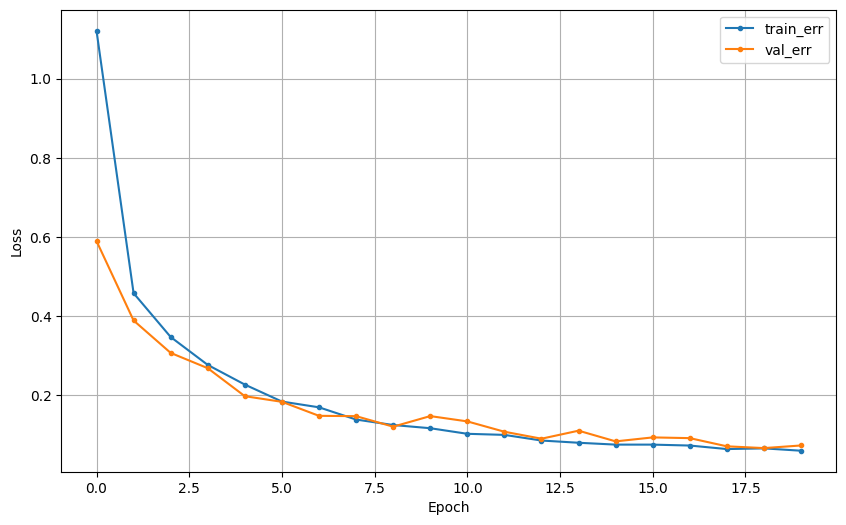

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

[[291   0   0   0   0   1]
 [  0 206  48   0   0   0]
 [  0   4 283   0   0   0]
 [  0   0   0 228   0   0]
 [  0   0   0   3 192   0]
 [  0   0   1  12   1 201]]

------------------------------------------------------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       292
           1       0.98      0.81      0.89       254
           2       0.85      0.99      0.91       287
           3       0.94      1.00      0.97       228
           4       0.99      0.98      0.99       195
           5       1.00      0.93      0.96       215

    accuracy                           0.95      1471
   macro avg       0.96      0.95      0.95      1471
weighted avg       0.96      0.95      0.95      1471



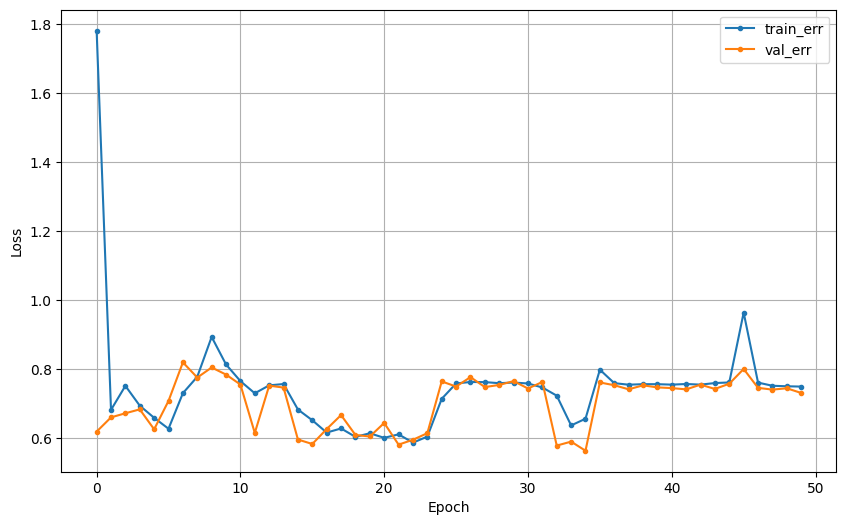

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

[[290   2   0   0   0   0]
 [  0  18 236   0   0   0]
 [  0   0 287   0   0   0]
 [  0   0   0 228   0   0]
 [  0   0   0 195   0   0]
 [  0   0   0 215   0   0]]

------------------------------------------------------------

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       292
           1       0.90      0.07      0.13       254
           2       0.55      1.00      0.71       287
           3       0.36      1.00      0.53       228
           4       0.00      0.00      0.00       195
           5       0.00      0.00      0.00       215

    accuracy                           0.56      1471
   macro avg       0.47      0.51      0.39      1471
weighted avg       0.52      0.56      0.44      1471



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


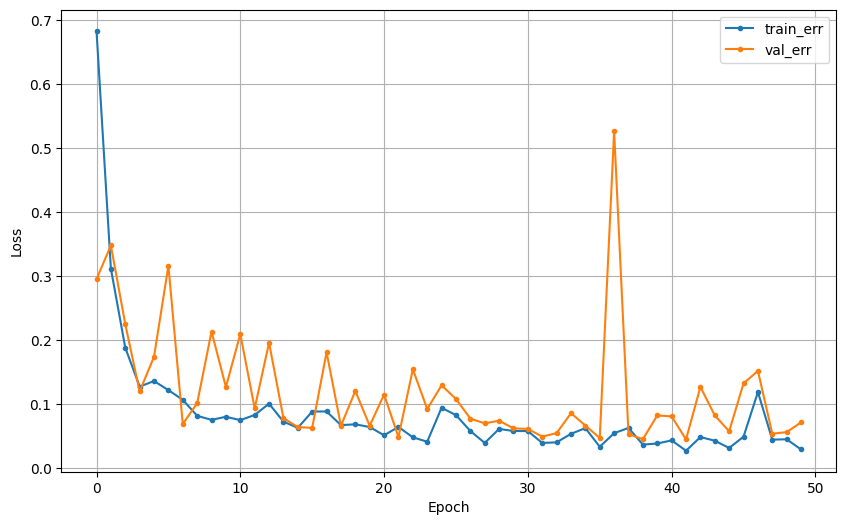

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

[[290   0   0   0   2   0]
 [  0 231  23   0   0   0]
 [  0  10 277   0   0   0]
 [  0   0   0 228   0   0]
 [  0   0   0   2 193   0]
 [  0   0   0   4   1 210]]

------------------------------------------------------------

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       292
           1       0.96      0.91      0.93       254
           2       0.92      0.97      0.94       287
           3       0.97      1.00      0.99       228
           4       0.98      0.99      0.99       195
           5       1.00      0.98      0.99       215

    accuracy                           0.97      1471
   macro avg       0.97      0.97      0.97      1471
weighted avg       0.97      0.97      0.97      1471



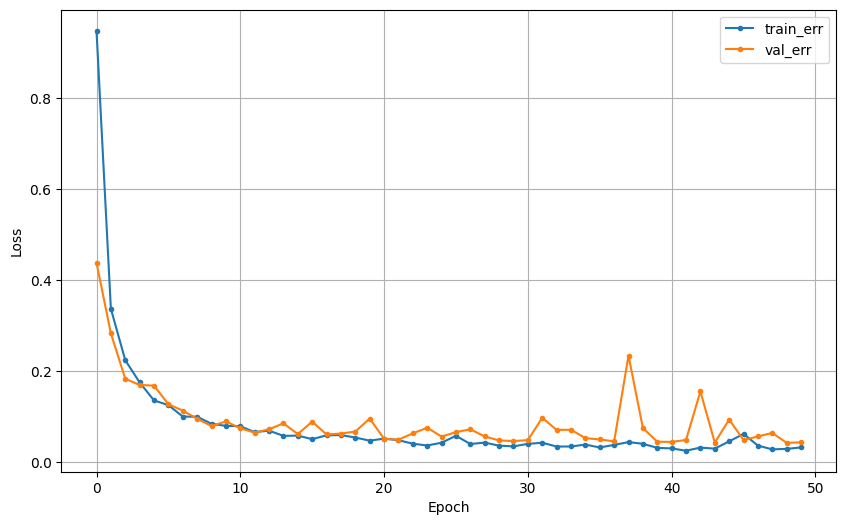

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

[[292   0   0   0   0   0]
 [  0 206  48   0   0   0]
 [  0   4 283   0   0   0]
 [  0   0   0 228   0   0]
 [  0   0   0   4 191   0]
 [  0   0   1   4   1 209]]

------------------------------------------------------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       292
           1       0.98      0.81      0.89       254
           2       0.85      0.99      0.91       287
           3       0.97      1.00      0.98       228
           4       0.99      0.98      0.99       195
           5       1.00      0.97      0.99       215

    accuracy                           0.96      1471
   macro avg       0.97      0.96      0.96      1471
weighted avg       0.96      0.96      0.96      1471



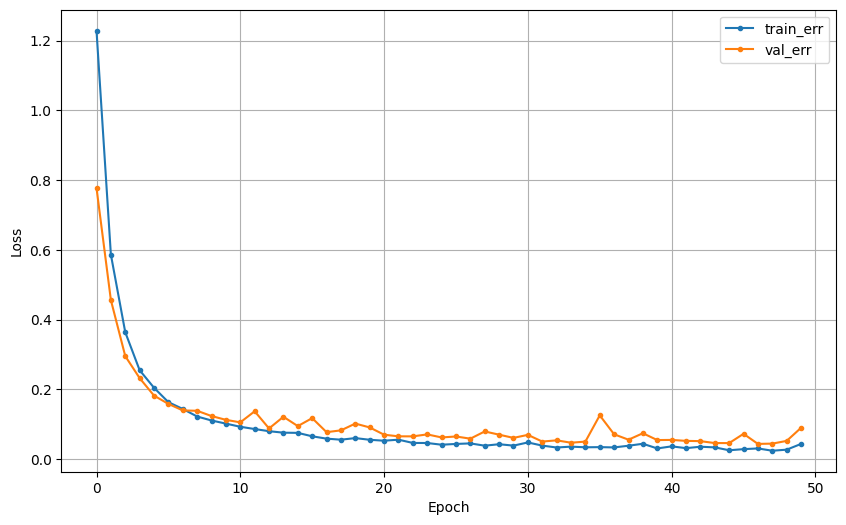

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

[[290   0   0   0   0   2]
 [  1 244   9   0   0   0]
 [  0  16 271   0   0   0]
 [  0   0   0 228   0   0]
 [  0   0   0   0 195   0]
 [  0   0   0   9   1 205]]

------------------------------------------------------------

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       292
           1       0.94      0.96      0.95       254
           2       0.97      0.94      0.96       287
           3       0.96      1.00      0.98       228
           4       0.99      1.00      1.00       195
           5       0.99      0.95      0.97       215

    accuracy                           0.97      1471
   macro avg       0.98      0.98      0.97      1471
weighted avg       0.97      0.97      0.97      1471



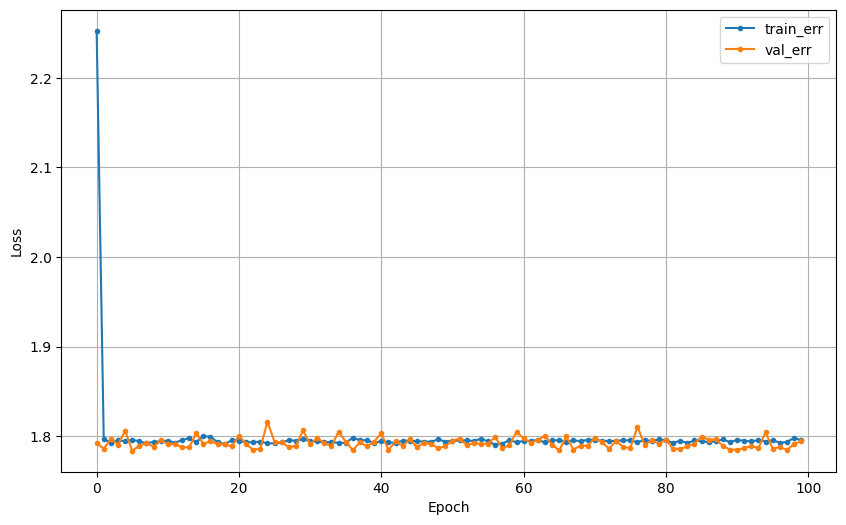

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

[[  0   0   0 292   0   0]
 [  0   0   0 254   0   0]
 [  0   0   0 287   0   0]
 [  0   0   0 228   0   0]
 [  0   0   0 195   0   0]
 [  0   0   0 215   0   0]]

------------------------------------------------------------

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       292
           1       0.00      0.00      0.00       254
           2       0.00      0.00      0.00       287
           3       0.15      1.00      0.27       228
           4       0.00      0.00      0.00       195
           5       0.00      0.00      0.00       215

    accuracy                           0.15      1471
   macro avg       0.03      0.17      0.04      1471
weighted avg       0.02      0.15      0.04      1471



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


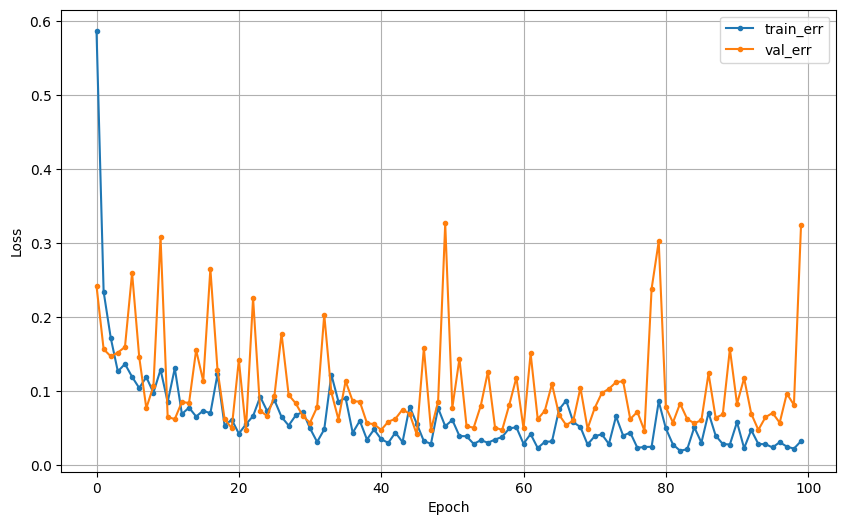

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

[[289   3   0   0   0   0]
 [  1 231  22   0   0   0]
 [  0   8 279   0   0   0]
 [  0   0   0 228   0   0]
 [  0   0   0  34 153   8]
 [  0   0   0  40   0 175]]

------------------------------------------------------------

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       292
           1       0.95      0.91      0.93       254
           2       0.93      0.97      0.95       287
           3       0.75      1.00      0.86       228
           4       1.00      0.78      0.88       195
           5       0.96      0.81      0.88       215

    accuracy                           0.92      1471
   macro avg       0.93      0.91      0.92      1471
weighted avg       0.93      0.92      0.92      1471



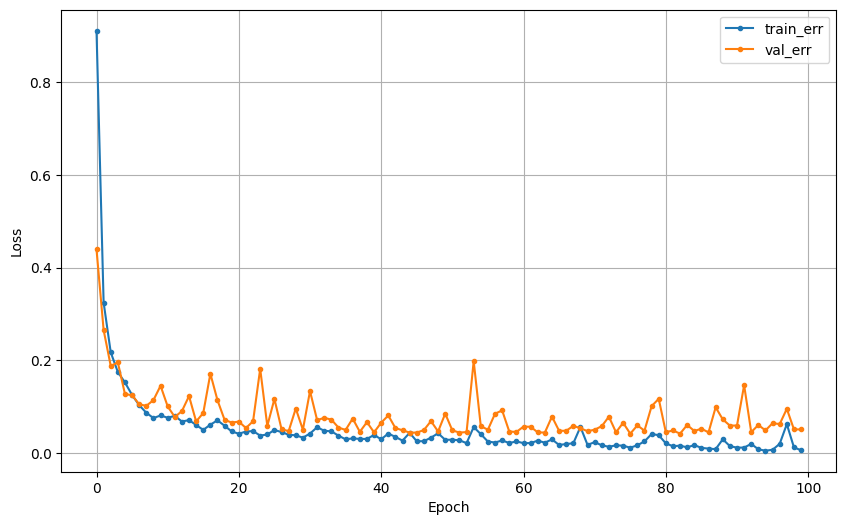

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

[[290   1   0   0   0   1]
 [  0 217  37   0   0   0]
 [  0   7 280   0   0   0]
 [  0   0   0 228   0   0]
 [  0   0   0   4 191   0]
 [  0   0   0   6   1 208]]

------------------------------------------------------------

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       292
           1       0.96      0.85      0.91       254
           2       0.88      0.98      0.93       287
           3       0.96      1.00      0.98       228
           4       0.99      0.98      0.99       195
           5       1.00      0.97      0.98       215

    accuracy                           0.96      1471
   macro avg       0.97      0.96      0.96      1471
weighted avg       0.96      0.96      0.96      1471



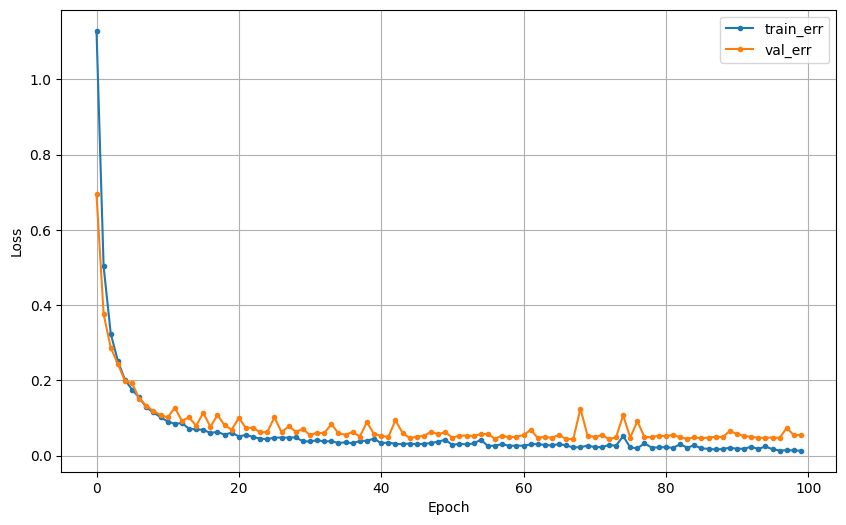

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

[[290   1   0   0   0   1]
 [  1 226  27   0   0   0]
 [  0   6 281   0   0   0]
 [  0   0   0 228   0   0]
 [  0   0   0   2 193   0]
 [  0   0   0   5   1 209]]

------------------------------------------------------------

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       292
           1       0.97      0.89      0.93       254
           2       0.91      0.98      0.94       287
           3       0.97      1.00      0.98       228
           4       0.99      0.99      0.99       195
           5       1.00      0.97      0.98       215

    accuracy                           0.97      1471
   macro avg       0.97      0.97      0.97      1471
weighted avg       0.97      0.97      0.97      1471



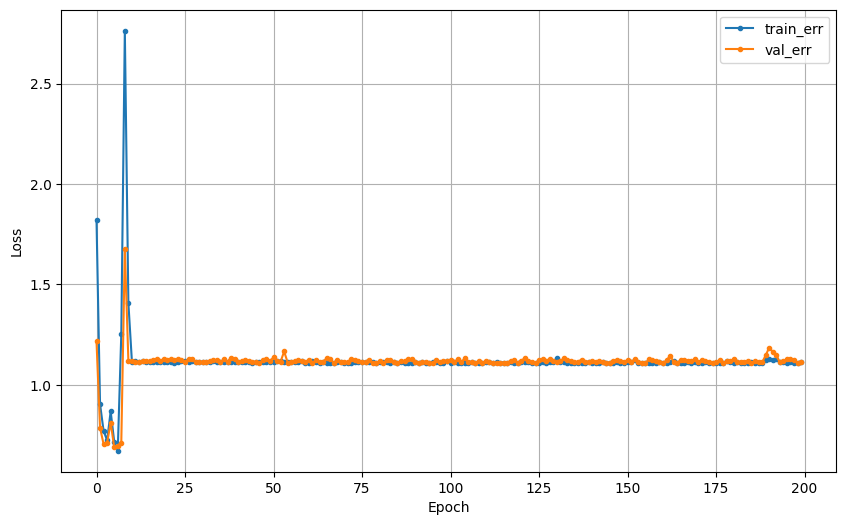

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

[[  0 289   0   3   0   0]
 [  0 252   0   2   0   0]
 [  0 287   0   0   0   0]
 [  0   0   0 228   0   0]
 [  0   0   0 195   0   0]
 [  0   0   0 215   0   0]]

------------------------------------------------------------

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       292
           1       0.30      0.99      0.47       254
           2       0.00      0.00      0.00       287
           3       0.35      1.00      0.52       228
           4       0.00      0.00      0.00       195
           5       0.00      0.00      0.00       215

    accuracy                           0.33      1471
   macro avg       0.11      0.33      0.16      1471
weighted avg       0.11      0.33      0.16      1471



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


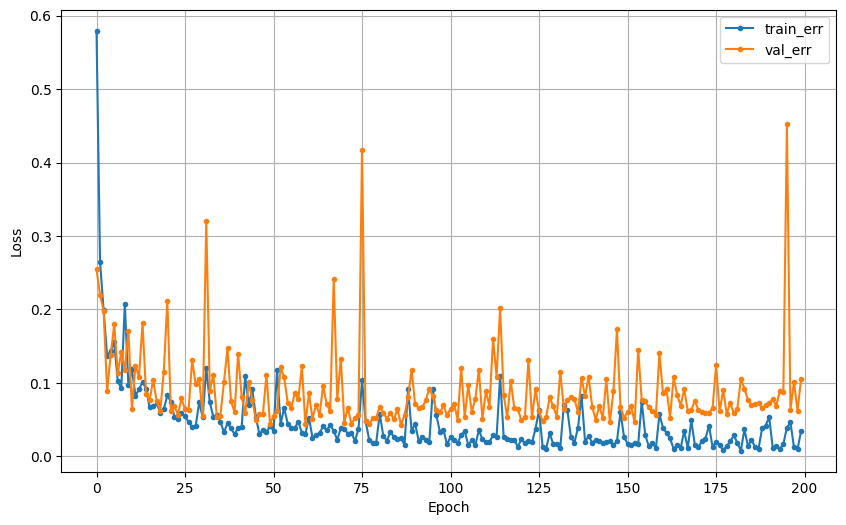

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

[[292   0   0   0   0   0]
 [  0 237  17   0   0   0]
 [  0  13 274   0   0   0]
 [  0   0   0 228   0   0]
 [  0   0   0   6 188   1]
 [  0   0   0  13   0 202]]

------------------------------------------------------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       292
           1       0.95      0.93      0.94       254
           2       0.94      0.95      0.95       287
           3       0.92      1.00      0.96       228
           4       1.00      0.96      0.98       195
           5       1.00      0.94      0.97       215

    accuracy                           0.97      1471
   macro avg       0.97      0.97      0.97      1471
weighted avg       0.97      0.97      0.97      1471



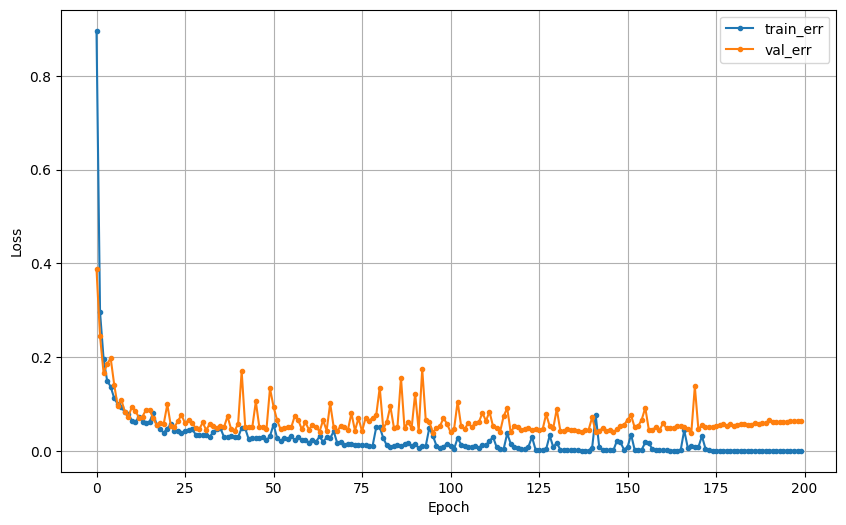

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

[[291   1   0   0   0   0]
 [  0 228  26   0   0   0]
 [  0   9 278   0   0   0]
 [  0   0   0 228   0   0]
 [  0   0   0   4 191   0]
 [  0   0   0   8   1 206]]

------------------------------------------------------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       292
           1       0.96      0.90      0.93       254
           2       0.91      0.97      0.94       287
           3       0.95      1.00      0.97       228
           4       0.99      0.98      0.99       195
           5       1.00      0.96      0.98       215

    accuracy                           0.97      1471
   macro avg       0.97      0.97      0.97      1471
weighted avg       0.97      0.97      0.97      1471



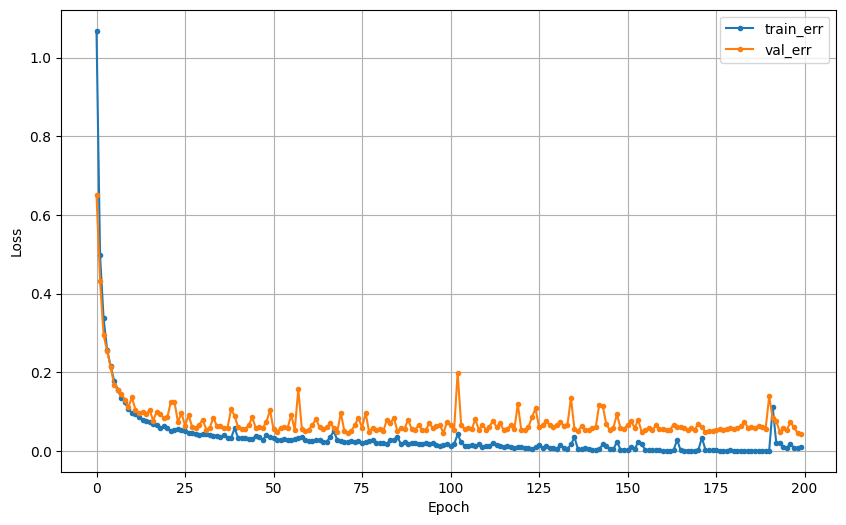

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

[[292   0   0   0   0   0]
 [  0 213  41   0   0   0]
 [  0   4 283   0   0   0]
 [  0   0   0 228   0   0]
 [  0   0   0   3 192   0]
 [  0   0   0   7   3 205]]

------------------------------------------------------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       292
           1       0.98      0.84      0.90       254
           2       0.87      0.99      0.93       287
           3       0.96      1.00      0.98       228
           4       0.98      0.98      0.98       195
           5       1.00      0.95      0.98       215

    accuracy                           0.96      1471
   macro avg       0.97      0.96      0.96      1471
weighted avg       0.96      0.96      0.96      1471



In [214]:
model2_final, model2_maxAcc = hyperparameter_tuning()

In [216]:
model2_maxAcc

0.9742

### (3) 모델3

In [240]:
def modeling3():
  clear_session()

  drop_rate = 0.2

  model3 = Sequential([Input(shape = (nfeatures,)),
                       Dense(128, activation='relu'),
                       Dropout(drop_rate),
                       Dense(64, activation='relu'),
                       Dropout(drop_rate),
                       Dense(32, activation='relu'),
                       Dropout(drop_rate),
                       Dense(16, activation='relu'),
                       Dropout(drop_rate),
                       Dense(6, activation='softmax')])
  return model3

#model2.summary()

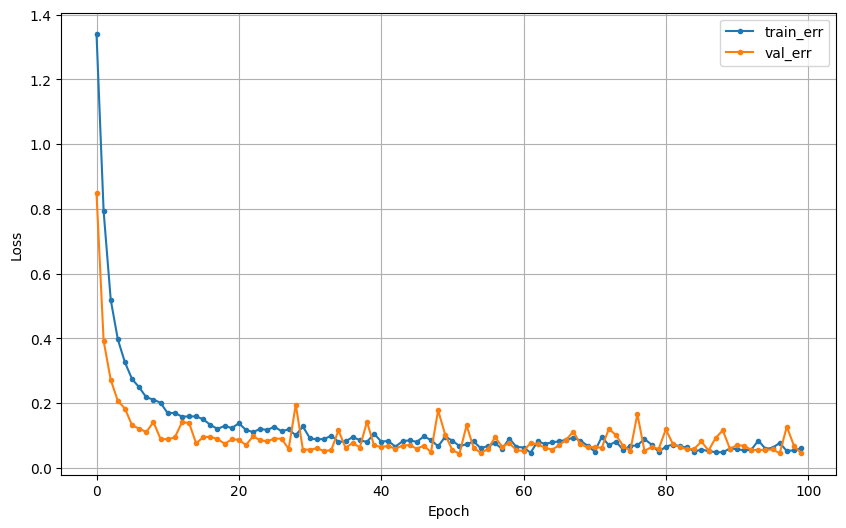

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

[[292   0   0   0   0   0]
 [  0 208  46   0   0   0]
 [  0   3 284   0   0   0]
 [  0   0   0 228   0   0]
 [  0   0   0   2 193   0]
 [  0   0   0   8   1 206]]

------------------------------------------------------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       292
           1       0.99      0.82      0.89       254
           2       0.86      0.99      0.92       287
           3       0.96      1.00      0.98       228
           4       0.99      0.99      0.99       195
           5       1.00      0.96      0.98       215

    accuracy                           0.96      1471
   macro avg       0.97      0.96      0.96      1471
weighted avg       0.96      0.96      0.96      1471



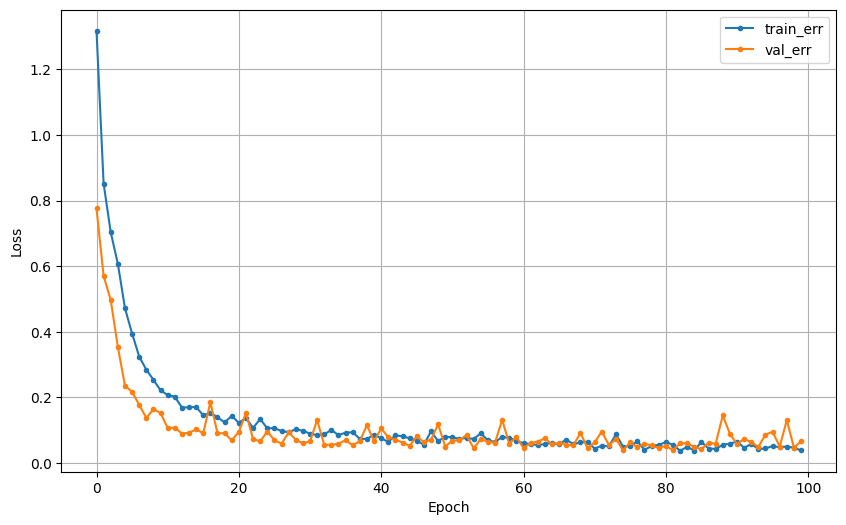

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

[[292   0   0   0   0   0]
 [  0 234  20   0   0   0]
 [  0  11 276   0   0   0]
 [  0   0   0 228   0   0]
 [  0   0   0   3 192   0]
 [  0   0   0   7   0 208]]

------------------------------------------------------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       292
           1       0.96      0.92      0.94       254
           2       0.93      0.96      0.95       287
           3       0.96      1.00      0.98       228
           4       1.00      0.98      0.99       195
           5       1.00      0.97      0.98       215

    accuracy                           0.97      1471
   macro avg       0.97      0.97      0.97      1471
weighted avg       0.97      0.97      0.97      1471



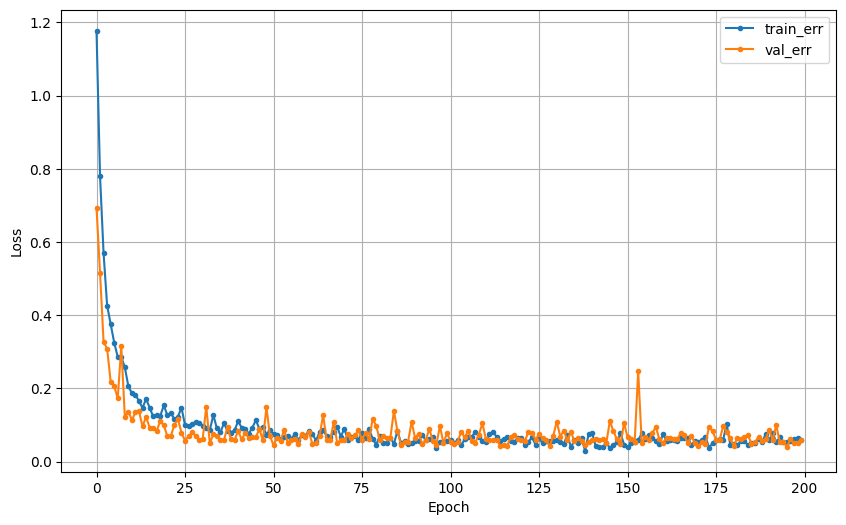

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

[[292   0   0   0   0   0]
 [  0 244  10   0   0   0]
 [  0  10 277   0   0   0]
 [  0   0   0 228   0   0]
 [  0   0   0   1 194   0]
 [  0   0   0   3   1 211]]

------------------------------------------------------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       292
           1       0.96      0.96      0.96       254
           2       0.97      0.97      0.97       287
           3       0.98      1.00      0.99       228
           4       0.99      0.99      0.99       195
           5       1.00      0.98      0.99       215

    accuracy                           0.98      1471
   macro avg       0.98      0.98      0.98      1471
weighted avg       0.98      0.98      0.98      1471



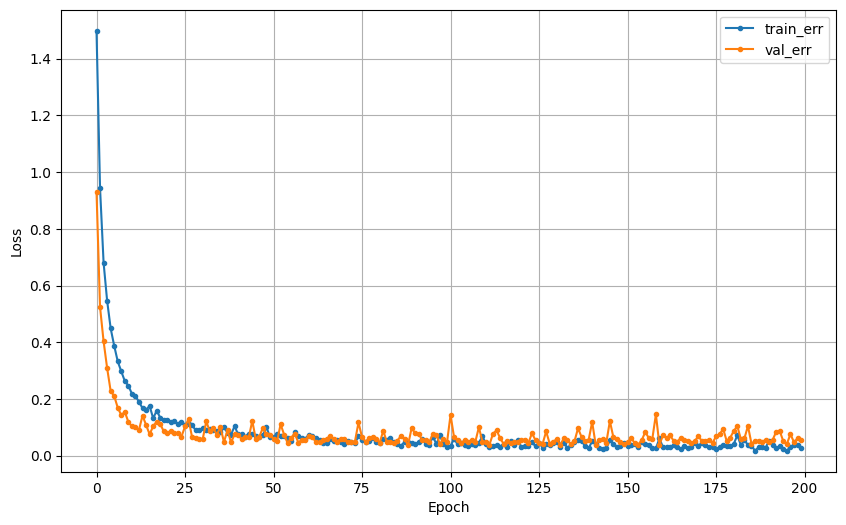

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

[[292   0   0   0   0   0]
 [  0 209  45   0   0   0]
 [  0   2 285   0   0   0]
 [  0   0   0 227   1   0]
 [  0   0   0   0 195   0]
 [  0   0   0   2   1 212]]

------------------------------------------------------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       292
           1       0.99      0.82      0.90       254
           2       0.86      0.99      0.92       287
           3       0.99      1.00      0.99       228
           4       0.99      1.00      0.99       195
           5       1.00      0.99      0.99       215

    accuracy                           0.97      1471
   macro avg       0.97      0.97      0.97      1471
weighted avg       0.97      0.97      0.96      1471



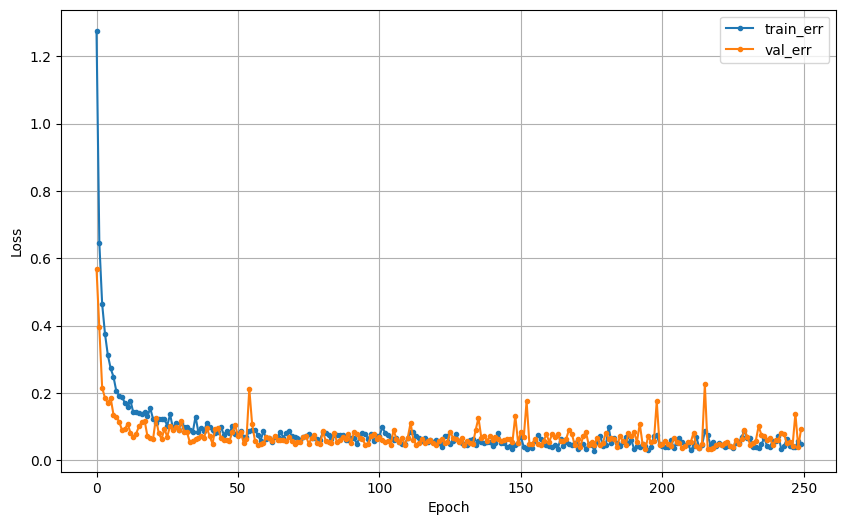

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

[[291   0   0   0   1   0]
 [  0 196  58   0   0   0]
 [  0   3 284   0   0   0]
 [  0   0   0 228   0   0]
 [  0   0   0   1 194   0]
 [  0   0   0   9   1 205]]

------------------------------------------------------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       292
           1       0.98      0.77      0.87       254
           2       0.83      0.99      0.90       287
           3       0.96      1.00      0.98       228
           4       0.99      0.99      0.99       195
           5       1.00      0.95      0.98       215

    accuracy                           0.95      1471
   macro avg       0.96      0.95      0.95      1471
weighted avg       0.96      0.95      0.95      1471



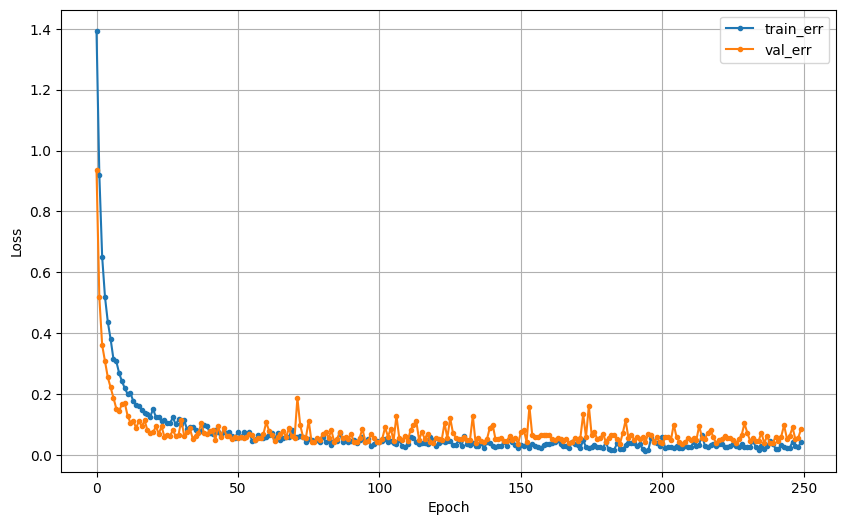

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

[[292   0   0   0   0   0]
 [  1 240  13   0   0   0]
 [  0  10 277   0   0   0]
 [  0   0   0 228   0   0]
 [  0   0   0   4 190   1]
 [  0   0   0   5   0 210]]

------------------------------------------------------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       292
           1       0.96      0.94      0.95       254
           2       0.96      0.97      0.96       287
           3       0.96      1.00      0.98       228
           4       1.00      0.97      0.99       195
           5       1.00      0.98      0.99       215

    accuracy                           0.98      1471
   macro avg       0.98      0.98      0.98      1471
weighted avg       0.98      0.98      0.98      1471



In [241]:
model3_info = hyperparameter_tuning(modeling3)

In [242]:
print(model3_info[1:])

(0.983, 200, 0.001)


### (4) 모델4

In [235]:
def modeling4():
  clear_session()

  drop_rate = 0.2

  model4 = Sequential([Input(shape = (nfeatures,)),
                       Dense(128, activation='relu'),
                       Dropout(drop_rate),
                       Dense(64, activation='relu'),
                       Dropout(drop_rate),
                       Dense(32, activation='relu'),
                       Dropout(drop_rate),
                       Dense(16, activation='relu'),
                       Dropout(drop_rate),
                       Dense(6, activation='softmax')])
  return model4

#model2.summary()

In [236]:
min_de = 0.001
patience = 5
es = EarlyStopping(monitor = 'val_loss', min_delta=min_de, patience=patience)

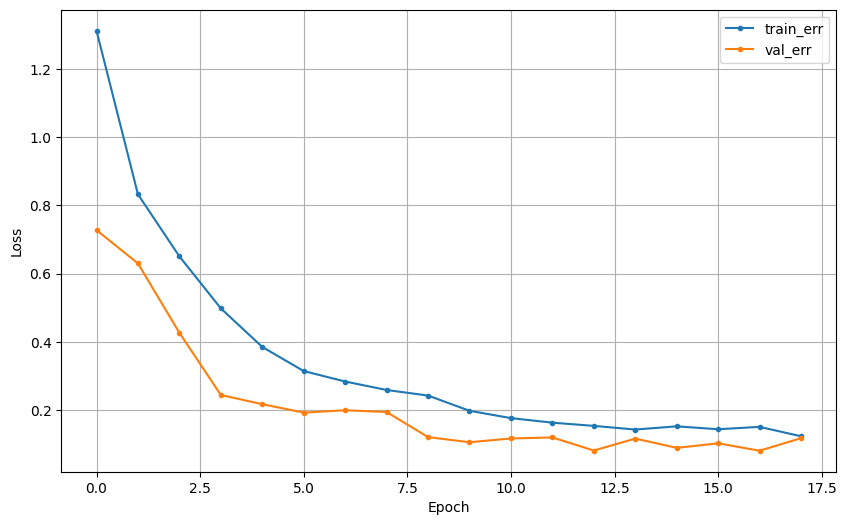

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

[[290   0   0   0   2   0]
 [  0 243  11   0   0   0]
 [  0  29 258   0   0   0]
 [  0   0   0 228   0   0]
 [  0   0   0   1 194   0]
 [  0   0   0   6   2 207]]

------------------------------------------------------------

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       292
           1       0.89      0.96      0.92       254
           2       0.96      0.90      0.93       287
           3       0.97      1.00      0.98       228
           4       0.98      0.99      0.99       195
           5       1.00      0.96      0.98       215

    accuracy                           0.97      1471
   macro avg       0.97      0.97      0.97      1471
weighted avg       0.97      0.97      0.97      1471



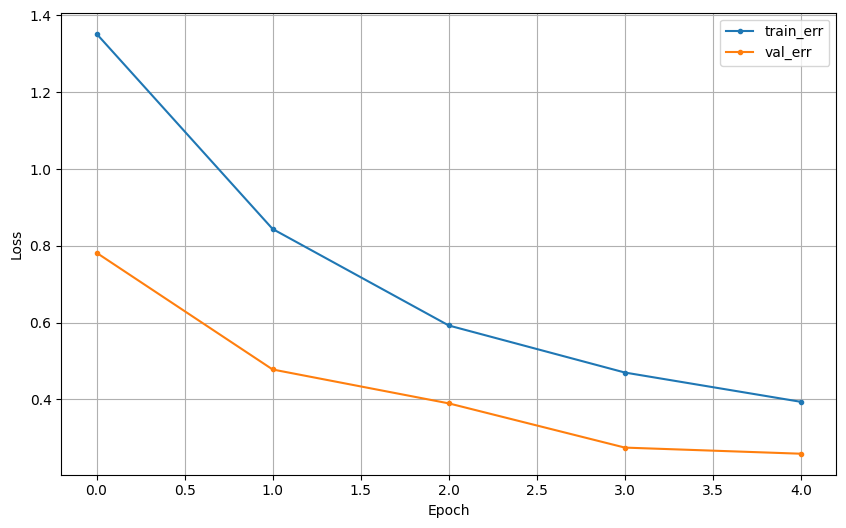

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

[[292   0   0   0   0   0]
 [  4 152  98   0   0   0]
 [  0   7 280   0   0   0]
 [  0   0   0 228   0   0]
 [  0   0   0  14 180   1]
 [  0   1   0  26   1 187]]

------------------------------------------------------------

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       292
           1       0.95      0.60      0.73       254
           2       0.74      0.98      0.84       287
           3       0.85      1.00      0.92       228
           4       0.99      0.92      0.96       195
           5       0.99      0.87      0.93       215

    accuracy                           0.90      1471
   macro avg       0.92      0.89      0.90      1471
weighted avg       0.91      0.90      0.89      1471



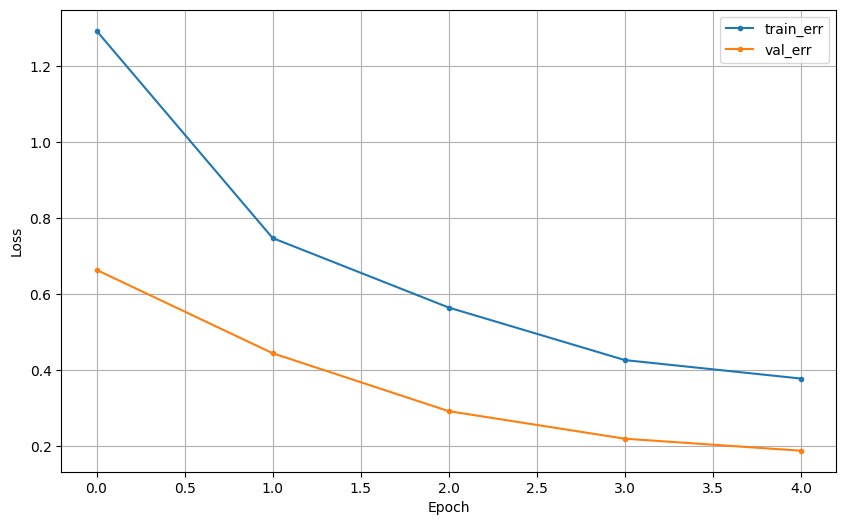

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

[[292   0   0   0   0   0]
 [  6 165  83   0   0   0]
 [  0   5 282   0   0   0]
 [  0   0   0 226   1   1]
 [  0   0   0   5 189   1]
 [  0   0   0   9   4 202]]

------------------------------------------------------------

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       292
           1       0.97      0.65      0.78       254
           2       0.77      0.98      0.87       287
           3       0.94      0.99      0.97       228
           4       0.97      0.97      0.97       195
           5       0.99      0.94      0.96       215

    accuracy                           0.92      1471
   macro avg       0.94      0.92      0.92      1471
weighted avg       0.93      0.92      0.92      1471



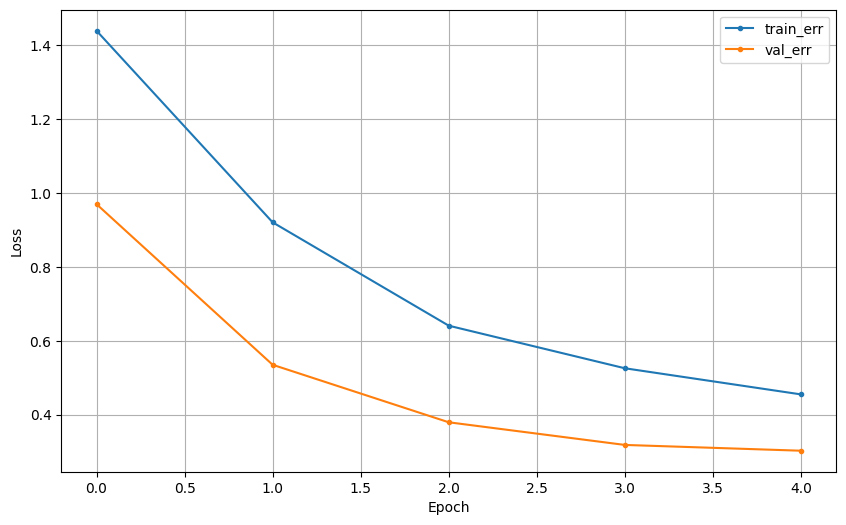

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

[[290   0   0   0   2   0]
 [  0 178  76   0   0   0]
 [  0  44 243   0   0   0]
 [  0   0   0 228   0   0]
 [  0   0   0  14 181   0]
 [  0   0   0  36   4 175]]

------------------------------------------------------------

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       292
           1       0.80      0.70      0.75       254
           2       0.76      0.85      0.80       287
           3       0.82      1.00      0.90       228
           4       0.97      0.93      0.95       195
           5       1.00      0.81      0.90       215

    accuracy                           0.88      1471
   macro avg       0.89      0.88      0.88      1471
weighted avg       0.89      0.88      0.88      1471



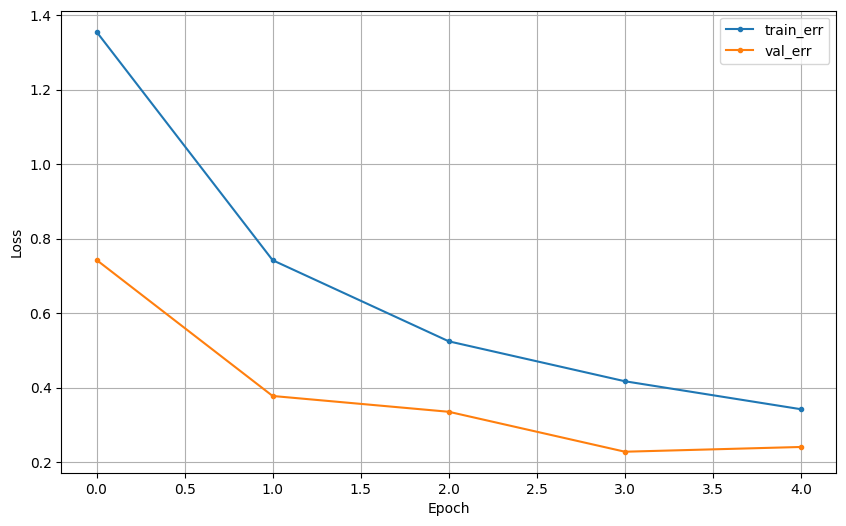

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

[[292   0   0   0   0   0]
 [  3 224  27   0   0   0]
 [  0  68 219   0   0   0]
 [  0   0   0 228   0   0]
 [  0   0   0  23 172   0]
 [  0   0   1  53   2 159]]

------------------------------------------------------------

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       292
           1       0.77      0.88      0.82       254
           2       0.89      0.76      0.82       287
           3       0.75      1.00      0.86       228
           4       0.99      0.88      0.93       195
           5       1.00      0.74      0.85       215

    accuracy                           0.88      1471
   macro avg       0.90      0.88      0.88      1471
weighted avg       0.90      0.88      0.88      1471



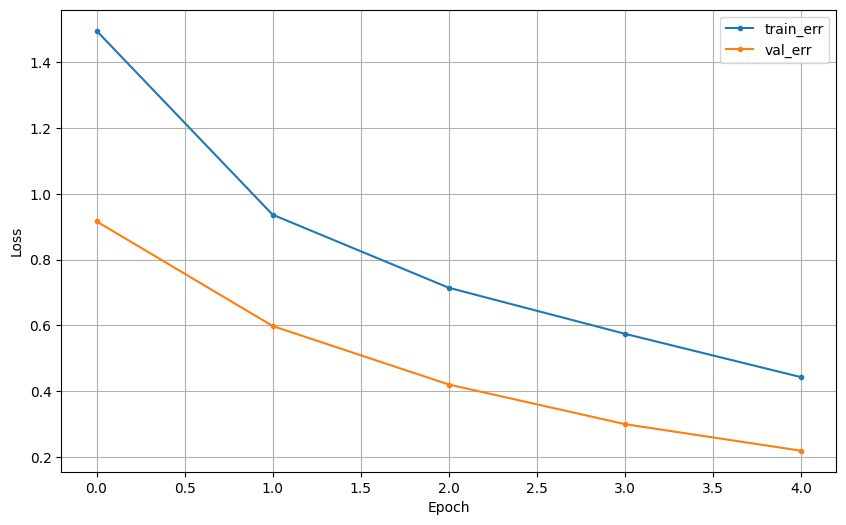

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

[[292   0   0   0   0   0]
 [  4 192  58   0   0   0]
 [  0  35 252   0   0   0]
 [  0   0   0 225   2   1]
 [  0   0   0   3 191   1]
 [  0   0   0  14  15 186]]

------------------------------------------------------------

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       292
           1       0.85      0.76      0.80       254
           2       0.81      0.88      0.84       287
           3       0.93      0.99      0.96       228
           4       0.92      0.98      0.95       195
           5       0.99      0.87      0.92       215

    accuracy                           0.91      1471
   macro avg       0.91      0.91      0.91      1471
weighted avg       0.91      0.91      0.91      1471



In [237]:
model4_info = hyperparameter_tuning(modeling4, callback=[es])

## 4.성능비교

* 세부 요구사항
    - test 데이터에 대한 전처리
    - 각 모델에 대해서 test 데이터로 성능 측정